### Topic Analysis

The implementation is based on the paper "Large-scale ComputerizedText Analysis in PoliticalScience: Opportunities andChallenges" by John Wilkerson and Andreu Casas available at : http://andreucasas.com/wilkerson_casas_2016_annual_review.pdf and applied on french speeches

In [1]:
### imports
import pandas as pd
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import re

In [2]:
### globals
dataDir = "dataset/"
dataName = "speech_test_small"
stemmer = SnowballStemmer("french")

#### Get the data & clean

Todo:
improve the cleaning:
    - remove named entities
    - better stop words list
    - nltk french stemmer sometimes stem in english ???

In [3]:
#get the dataset
data = pd.read_csv(dataDir + dataName, sep='|', header=None, names=["author", "speech"])

#add index column to dataset
corpus = data[['speech']]
corpus['index'] = corpus.index

def clear_strict(doc):
    doc = doc[0]
    doc = doc.split('.')
    noun = ["AGNES PANNIER-RUNACHER", "JULIEN DENORMANDIE", "SONIA MABROUK", "SOPHIE CLUZEL", "PATRICK ROGER", "MARC FAUVELLE"]
    i = 0
    for n in noun:
        if n in doc[1]:
            doc = ".".join([sent for sent in doc[2:]])
            break
        i += 1
    if i == len(noun):
        doc = ".".join([sent for sent in doc[1:]])
    for n in noun:
        doc = doc.lower().replace(n.lower(), "")
    return doc
        
corpus[["speech"]] = corpus[["speech"]].apply(clear_strict, axis=1)
#corpus.head
#print("taille corpus: " + str(len(corpus)))
#print(corpus.head)

###### custom stopword list

In [4]:
#globals

#more complete stoplist
def get_stop(file):
    f = open(file, 'r')
    return list(filter(lambda x: x != "valeur", map(lambda x : x[:-1], f.readlines()[:-1])))

stopword = get_stop("fr-stopword.txt")

##### stemming

change for stanford lemmatizer

In [5]:
def stemming(text):
    return stemmer.stem(text)
    
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in nltk.corpus.stopwords.words('french') and token not in stopword and len(token) > 3 and "bonjour" not in token:
            result.append(stemming(token))
    return result

#speech_ex = corpus[corpus.index == 0]
#speech = speech_ex.speech.values[0]
#print(preprocess(speech))

In [6]:
process_corpus = corpus.speech.map(preprocess)

In [7]:
#process_corpus.head

#### Bag of word + Tf-idf

Todo:
parameters tuning for optimal filtering

In [8]:
#bag of words
dic = gensim.corpora.Dictionary(process_corpus)
#filter
minimum = 6
maximum = 0.5
dic.filter_extremes(no_below=minimum, no_above=maximum, keep_n=100000)

In [9]:
#doc2bow
bow_corpus = [dic.doc2bow(speech) for speech in process_corpus]
#print(bow_corpus[0])
#print(len(dic))

In [10]:
#tf-idf
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


#### Lda on tf-idf corpus

In [11]:
#lda printing
def topic_print(model):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))

In [12]:
#lda tfidf
#Since we don't know how many topics we can find in speeches, we generate a range models with variable topics
def lda_generate_models():
    lda_models = []
    num_top = 10
    size = 0
    for i in range(num_top, 95, 5):
        lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=i, id2word=dic, passes=2, workers=4)
        #lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_top, id2word=dic, passes=2, workers=2)
        lda_models.append(lda_model)
        size += len(lda_model.get_topics())
    return lda_models, size

lda_models, size = lda_generate_models()

#### Spectral Clustering based on cosine similarity for Topic Model stability

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
#cosine similarities between all pairs of topics

topics = np.vstack([topics.get_topics() for topics in lda_models])
   
def cosine_sym(a, b):
    a = a.reshape(1, -1)
    b = b.reshape(1, -1)
    return cosine_similarity(a, b)

# a . b / ||a|| * || b ||
def calc_symm(topics):
    dot = np.dot(topics, topics.T)
    scal = np.zeros(dot.shape[0])
    for i in range(0, len(dot)):
        scal[i] = np.sqrt(dot[i][i])
    sym = np.zeros((dot.shape))
    for i in range(0, len(dot)):
        for j in range(0, len(dot)):
            sym[i][j] = dot[i][j] / (scal[i] * scal[j])
    return sym

sym = calc_symm(topics)

In [15]:
print(sym[1][1]) #diag must be ~= 1.0

1.000000067806309


In [16]:
from sklearn.cluster import SpectralClustering

spec = SpectralClustering(n_clusters=20, affinity='precomputed')
spec.fit(sym)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=20, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=None)

##### Transformation des clusters en méta-sujets

Todo: Regroupement des clusters en méta-sujet par une analyse de mot-clef. 

example: 

"Il faut préserver la biodiversité de nos écosystèmes si nous voulons pouvoir survivre sur le long terme"

Domaine :  Méta-topic: Environment ; Topic: Biodiversité, préservation. 

Dans la présentation des résultats ci-dessous on remarque très bien les topics ayant le même meta-sujet.
Comme dans les résultats du papier cité au début du notebook, on peut clairement voir un cluster "unclear" qui regroupe beaucoup de topics.

#### utility function to display the result

In [17]:

def regroup_topics_from_clust(labels):
    regroup_topics = {}
    for clust in set(labels):
        regroup_topics[clust] = topics[labels == clust]
    return regroup_topics

def size_cluster(regrouped):
    clust_size = {}
    for clust in regrouped.keys():
        clust_size[clust] = len(regrouped[clust])
    return clust_size

def get_top_words_clust(tops):
    sum_topics = np.sum(tops, axis=0)
    idx = np.argpartition(sum_topics, -5)[-5:]
    words = [dic[i] for i in idx]
    return words
    
def top_words_clusters(regrouped):
    top_words = {}
    for clust in regrouped.keys():
        top_words[clust] = get_top_words_clust(regrouped[clust])
    return top_words

#### Observations & results on training

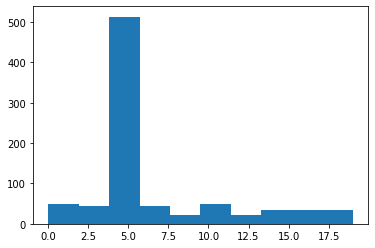

Size of clusters: 
{0: 36, 1: 13, 2: 14, 3: 30, 4: 503, 5: 10, 6: 10, 7: 34, 8: 11, 9: 12, 10: 20, 11: 30, 12: 12, 13: 11, 14: 12, 15: 22, 16: 18, 17: 17, 18: 13, 19: 22}


In [21]:
"""
Distribution des topics dans les différents clusters
Top words per cluster
"""

import matplotlib.pyplot as plt

plt.hist(spec.labels_)
plt.show()

regrouped_topics = regroup_topics_from_clust(spec.labels_)
clusters_size = size_cluster(regrouped_topics)
print("Size of clusters: ")
print(clusters_size)

In [19]:
top_words = top_words_clusters(regrouped_topics)
print("Top words per clusters: ")
print(top_words)

Top words per clusters: 
{0: ['cooper', 'ouvertur', 'shangh', 'chinois', 'agend'], 1: ['champ', 'travailleur', 'détach', 'professionnel', 'format'], 2: ['chinois', 'problem', 'origin', 'immigr', 'illégal'], 3: ['élabor', 'procédur', 'décret', 'nicol', 'ordon'], 4: ['handicap', 'immeubl', 'libert', 'biodivers', 'emploi'], 5: ['statut', 'ordon', 'immeubl', 'syndicat', 'facilit'], 6: ['carbon', 'électr', 'industr', 'secrétair', 'fili'], 7: ['milliard', 'crédit', 'jean', 'euros', 'yve'], 8: ['vill', 'marchand', 'immeubl', 'log', 'jean'], 9: ['démocrat', 'référendum', 'élect', 'recommand', 'audit'], 10: ['mort', 'soldat', 'mémoir', 'monu', 'combatt'], 11: ['nation', 'terror', 'coalit', 'syr', 'uni'], 12: ['forum', 'touchent', 'cooper', 'exposit', 'visit'], 13: ['cris', 'évit', 'urgenc', 'dialogu', 'alimentair'], 14: ['éduc', 'prononc', 'jug', 'justic', 'mineur'], 15: ['régul', 'argent', 'privatis', 'jeux', 'hasard'], 16: ['terror', 'armé', 'combat', 'frer', 'sahel'], 17: ['libert', 'recherc

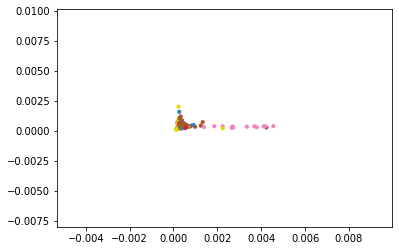

In [20]:
from itertools import cycle,islice

"""
From the cosine similarity matrix this is the spatial repartition of the cluster.
We can't visualise well since it's in 850 dim
"""

y_pred = spec.labels_.astype(np.int)
X = topics
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

##### results on validation

#### observation on test